# Supervised learning post-processing of CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this fourth notebook is to applying Supervised Learning to improve the quality CTscan imaging. We will be using a training dataset composed of several brain images and their corresponding FBP results for a CT aquisition with poor angle coverage. We wish to train a network to transform the FBP images into those of higher quality (assumed to be obtained using a a CT aquisition with better angle coverage). 

The problem that we wish to solve can be expressed as:

$$
\underset{\theta} {\mathrm{argmin}} \; \Vert \mathbf{x}- f_\theta(\mathbf{x}_{FBP}) \Vert_2^2
$$

where $f_\theta$ is the network.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch
import torch.nn as nn

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm, trange
from pylops import TorchOperator
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

from ct import CT2D
from unet2d import ResUNet
from plotting import plt_comparison

device = 'cpu'

## Load training dataset

In [2]:
# Load data
f = np.load('../data/brains_fbp_trainingdata.npz')
brains = f['brains']
brainsfbp = f['fbps']
nx, ny = brains[0].shape

In [3]:
brains.min(), brains.max(), brainsfbp.min(), brainsfbp.max()

(0.0043317433, 1.0, -0.44871506, 1.1350261)

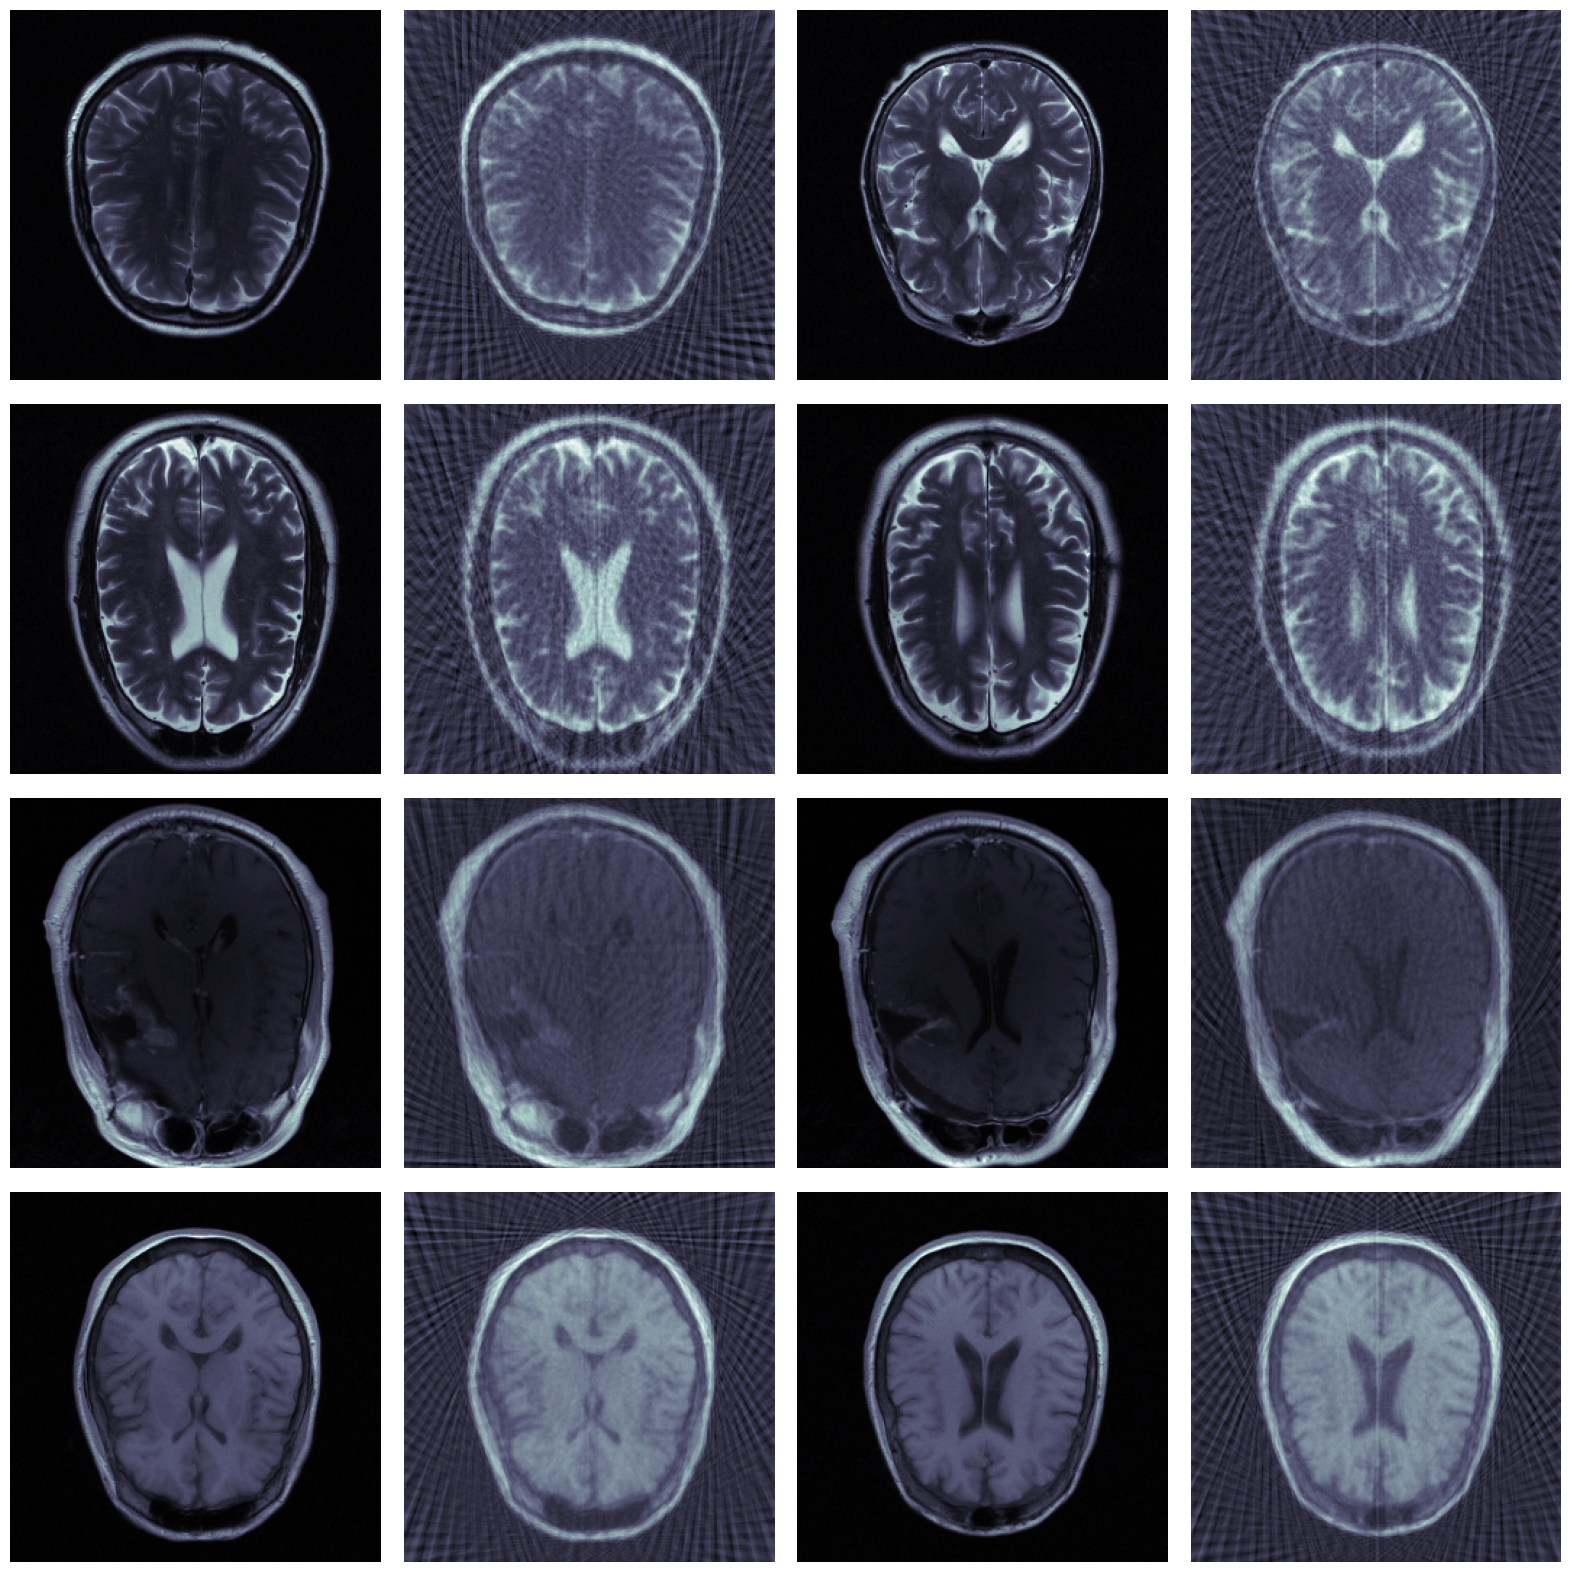

In [4]:
iimages = np.random.randint(0, len(brains), 4)
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(16, 16))

for iax, iimage in enumerate(iimages):
    axs[iax, 0].imshow(brains[iimage], cmap="bone")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(brainsfbp[iimage], cmap="bone")
    axs[iax, 1].axis("off")
    axs[iax, 2].imshow(brains[iimage+1], cmap="bone")
    axs[iax, 2].axis("off")
    axs[iax, 3].imshow(brainsfbp[iimage+1], cmap="bone")
    axs[iax, 3].axis("off")
plt.tight_layout()

In [5]:
# Create train/validation set
percent_valid = 0.4
nvalid = int(brains.shape[0] * percent_valid)
nvalid

X_train = brainsfbp[:-nvalid]
X_valid = brainsfbp[-nvalid:]

Y_train = brains[:-nvalid]
Y_valid = brains[-nvalid:]

In [6]:
# Convert Train Set to Torch
X_train = torch.from_numpy(X_train).float().unsqueeze(1)
Y_train = torch.from_numpy(Y_train).float().unsqueeze(1)
train_dataset = TensorDataset(X_train, Y_train)

# Define Valid Set to Torch
X_valid = torch.from_numpy(X_valid).float().unsqueeze(1)
Y_valid = torch.from_numpy(Y_valid).float().unsqueeze(1)
valid_dataset = TensorDataset(X_valid, Y_valid)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [7]:
network = ResUNet(1, 1, hidden_channels=8, levels=2, subsampling=[[2,  2], [2, 2]]).to(device)
network = network.apply(network.weights_init) 
summary(network, input_size=(1, 1, nx, ny))

[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.
/opt/anaconda3/envs/pylops/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Layer (type:depth-idx)                             Output Shape              Param #
ResUNet                                            [1, 1, 256, 256]          --
├─ResNetBlock: 1-1                                 [1, 8, 256, 256]          --
│    └─Sequential: 2-1                             [1, 8, 256, 256]          --
│    │    └─Conv2d: 3-1                            [1, 8, 256, 256]          8
│    │    └─BatchNorm2d: 3-2                       [1, 8, 256, 256]          16
│    └─Sequential: 2-2                             [1, 8, 256, 256]          --
│    │    └─Sequential: 3-3                        [1, 8, 256, 256]          88
│    │    └─Sequential: 3-4                        [1, 8, 256, 256]          592
│    └─LeakyReLU: 2-3                              [1, 8, 256, 256]          --
│    └─BatchNorm2d: 2-4                            [1, 8, 256, 256]          16
├─Sequential: 1-2                                  --                        --
│    └─ContractingBlock_Res: 2-5   

In [8]:
def train(model, criterion, optimizer, data_loader, device='cpu', plotflag=False):
    """Training step

    Perform a training step over the entire training data (1 epoch of training)

    Parameters
    ----------
    model : :obj:`torch.nn.Module`
        Model
    criterion : :obj:`torch.nn.modules.loss`
        Loss function
    optimizer : :obj:`torch.optim`
        Optimizer
    data_loader : :obj:`torch.utils.data.dataloader.DataLoader`
        Training dataloader
    device : :obj:`str`, optional
        Device


    Returns
    -------
    loss : :obj:`float`
        Loss over entire dataset
    
    """
    model.train()
    loss = 0
    for X, y in tqdm(data_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        yprob = model(X)
        ls = criterion(yprob, y)
        ls.backward()
        optimizer.step()
        loss += ls.item()
    loss /= len(data_loader)
    
    """
    if plotflag:
        fig, axs = plt.subplots(1, 2, figsize=(16, 5))
        show_tensor_images(X, ax=axs[0], num_images=15, vmin=-1, vmax=1)
        axs[0][0].set_title("Input")
        axs[0][0].axis('tight')
        show_tensor_images(y, ax=axs[1], num_images=15, vmin=0, vmax=1)
        axs[0][1].set_title("Output")
        axs[0][1].axis('tight')
        plt.show()
    """
    return loss


def evaluate(model, criterion, data_loader, device='cpu'):
    """Evaluation step

    Perform an evaluation step over the entire training data

    Parameters
    ----------
    model : :obj:`torch.nn.Module`
        Model
    criterion : :obj:`torch.nn.modules.loss`
        Loss function
    data_loader : :obj:`torch.utils.data.dataloader.DataLoader`
        Training dataloader
    device : :obj:`str`, optional
        Device

    Returns
    -------
    loss : :obj:`float`
        Loss over entire dataset
    
    """
    model.eval()
    loss = 0
    for X, y in tqdm(data_loader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad(): # use no_grad to avoid making the computational graph...
            yprob = model(X)
            ls = criterion(yprob, y)
        loss += ls.item()
    loss /= len(data_loader)
    return loss

In [ ]:
n_epochs = 30
lr = 1e-3

criterion = nn.MSELoss()
optim = torch.optim.Adam(network.parameters(), lr=lr)

train_loss_history = np.zeros(n_epochs)
valid_loss_history = np.zeros(n_epochs)

#t = trange(n_epochs, desc='Loss', leave=True)
for epoch in range(n_epochs):
    train_loss = train(network, criterion, optim, 
                       train_loader, device=device)
                       #plotflag=True if epoch%10==0 else False)
    valid_loss = evaluate(network, criterion, 
                          valid_loader, device=device)
    train_loss_history[epoch] = train_loss
    valid_loss_history[epoch] = valid_loss
    
    #t.set_description('Loss=%g' % train_loss)
    #t.refresh() # to show immediately the update

    print(f'Epoch {epoch}, Training Loss {train_loss:.4f}, Valid Loss {valid_loss:.4f}')

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(train_loss_history, 'k', lw=2, label='Train')
ax.plot(valid_loss_history, 'r', lw=2, label='Valid')
ax.set_title('Losses', fontweight='bold');

In [ ]:
Y_train_pred = network(X_train[:4])

fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(16, 16))

for iax, iimage in enumerate(range(4)):
    axs[iax, 0].imshow(X_train[iimage].squeeze(), cmap="bone")
    axs[iax, 0].axis("off")
    axs[iax, 1].imshow(Y_train[iimage].squeeze(), cmap="bone")
    axs[iax, 1].axis("off")
    axs[iax, 2].imshow(Y_train_pred[iimage].detach().numpy().squeeze(), cmap="bone")
    axs[iax, 2].axis("off")
plt.tight_layout()